In [1]:
from luxai_s2.env import LuxAI_S2
from luxai_s2.map.board import Board
from luxai_s2.map_generator.generator import GameMap
import matplotlib.pyplot as plt
import matplotlib
import logging
import numpy as np
from luxai_s2.utils import my_turn_to_place_factory
from agents_experiments import (reset_w_custom_board, IdleAgent, ControlledAgent, interact)
import uuid
from IPython.display import Video
from pprint import pprint

import pandas as pd
# import seaborn as sns

matplotlib.rc('font', size=14)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [2]:
# key-values of dict below should match attributes present in this class
# https://github.com/aernesto/Lux-Design-S2/blob/adrian/luxai_s2/luxai_s2/config.py#L34
environment_config = dict(
#         max_episode_length=350,  # how many total turns in game
#         CYCLE_LENGTH=50,
#         DAY_LENGTH=50,  # so no night
        MAX_RUBBLE=0,  # disable rubble   
        MIN_FACTORIES=2,  
        MAX_FACTORIES=2
    )
env = LuxAI_S2(**environment_config)
custom_rubble = np.zeros((env.env_cfg.map_size,) * 2, dtype=np.int64)

# Let's put a single ice at 30,30
custom_ice = np.zeros_like(custom_rubble)
custom_ice[30, 30] = 1

# Let's put a single ore at 21, 21
custom_ore = np.zeros_like(custom_rubble)
custom_ore[21, 21] = 1

custom_symmetry = None


custom_map_ = GameMap(custom_rubble, custom_ice, custom_ore, custom_symmetry)

simple_board = Board(
    seed=env.seed_rng.randint(0, 2**32 - 1, dtype=np.int64), 
    env_cfg=env.env_cfg,
    existing_map=custom_map_
)

obs, env = reset_w_custom_board(env, seed=41, custom_board=simple_board)
    
# source code of reset() method: 
# https://github.com/aernesto/Lux-Design-S2/blob/adrian/luxai_s2/luxai_s2/env.py#L175
# obs = env.reset(seed=41) # resets an environment with a seed

In [3]:
# first player cannot place factory on any boundary, so inner square has dimensions 46x46
# the 2 isolated resources remove each 9 tiles from the potential spawn locations
46*46- 9*2

2098

In [4]:
2098 -28

2070

In [5]:
logger.setLevel(logging.DEBUG)

filename = str(uuid.uuid4()) + '.mp4'
file_path = '/home/adrian_admin/prog/kaggle/lux-ai-2/Lux-Design-S2/data/experiments/adrian/'
animate_arg = ''  # file_path + filename
agents = {}
for player, agent_constructor in zip(env.agents, [IdleAgent, ControlledAgent]):
    logging.debug(player)
    agents[player] = agent_constructor(player, env.state.env_cfg) 
    
_ = interact(
    env, 
    agents, 
    30, 
    animate_=animate_arg, 
    break_at_first_action=False, 
    debug=False, 
    custom_board=simple_board
)
# print(last_obs)

DEBUG:root:player_0
DEBUG:root:player_1
/home/adrian_admin/miniconda3/envs/lux37/lib/python3.7/site-packages/pygame/sysfont.py:228: UserWarning: Process running 'fc-list' timed-out! System fonts cannot be loaded on your platform
  f"Process running '{path}' timed-out! System fonts cannot be loaded on "


In [6]:
if animate_arg:
    Video(animate_arg, embed=True)

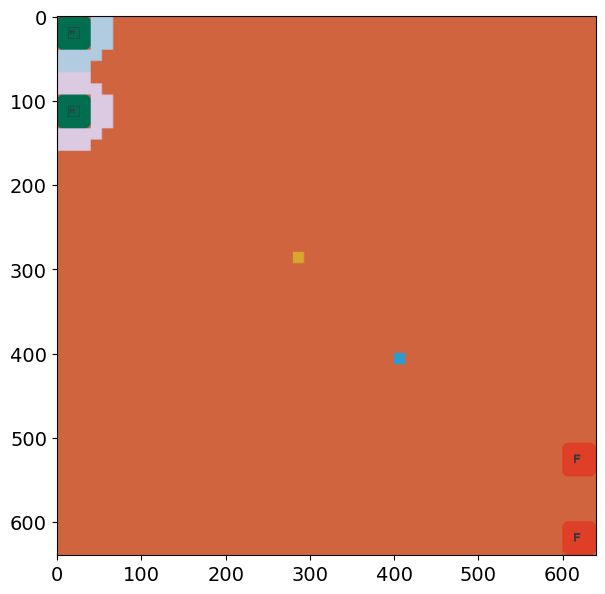

In [7]:
#video above is missing bottom pixels for some reason 
logger.setLevel(logging.INFO)
img = env.render("rgb_array", width=640, height=640)
f, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img);

In [8]:
stats_df = pd.DataFrame([s['factories_total'] for s in agents['player_1'].stats])
stats_df.head(3)

,ice,metal,ore,water,max_number_allowed,number_existing,power
0,0,0,0,0,2,0,0.0
1,0,0,0,0,2,0,0.0
2,0,150,0,150,2,1,1000.0


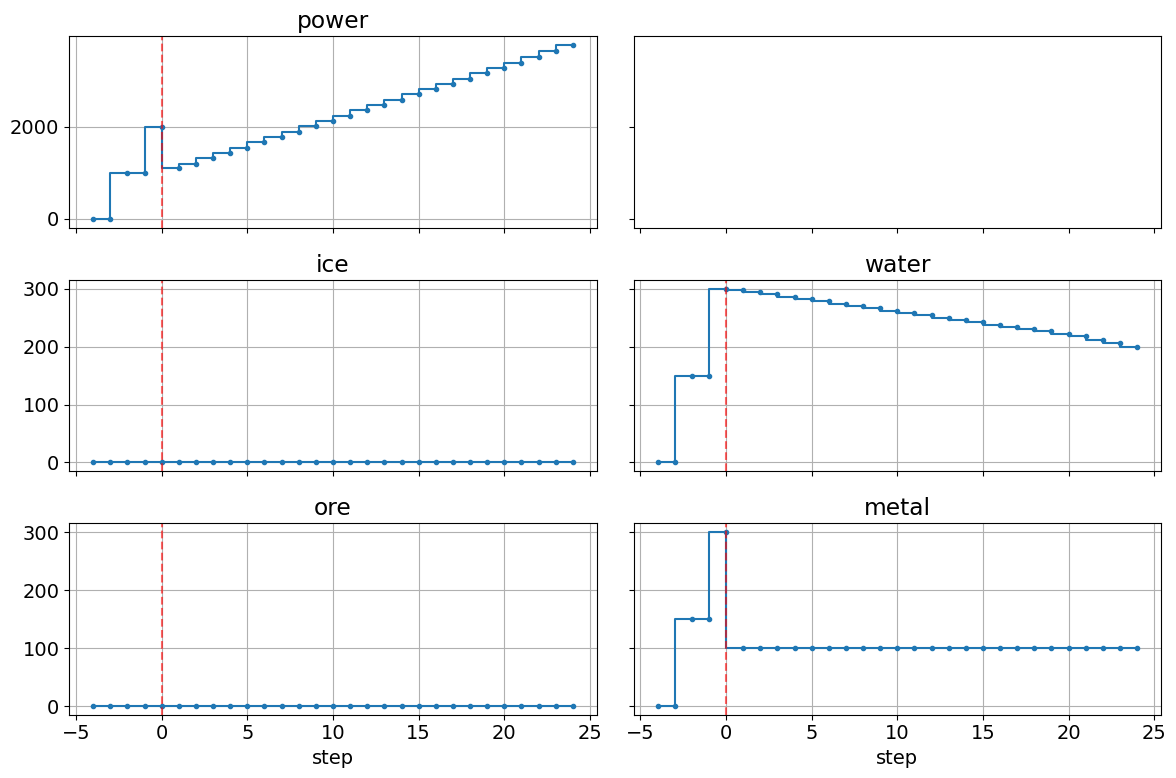

In [9]:
f, axes = plt.subplots(3, 2, figsize=(12, 8), sharex=True, sharey='row')
"""
power
ice water
ore metal
lichen
"""
axix = {
    'power': [0, 0],
    'lichen': [0, 1],
    'ice' : [1, 0],
    'water': [1, 1],
    'ore': [2, 0],
    'metal': [2, 1]
}
num_fac_allowed = stats_df.max_number_allowed.max()
pre_phase = num_fac_allowed * 2
for title, ix in axix.items():
    try:
        y = stats_df[title].values
    except KeyError:
        continue
    ax = axes[ix[0], ix[1]]
    ax.step(np.arange(-pre_phase, len(y) - pre_phase), y, where='pre', marker='.')
    ax.axvline(0, color='red', alpha=.6,linestyle='dashed')
    ax.grid('on');
    ax.set_title(title)
    if title in {'ore', 'metal'}:
        ax.set_xlabel('step')
f.tight_layout();